# Lassa data set evaluation

In [28]:
import pandas as pd
from matplotlib import pyplot as plt

In [29]:
def histograms(stats):
    # Creating histograms with custom labels
    fig, axes = plt.subplots(1, 4, figsize=(10, 3))  # Adjust grid if you have a different layout

    stats[['N_share', 'Length', 'RelativeLength', 'RelativeError']].hist(
        bins=50, log=True, ax=axes
    )

    # Setting y-axis label for the left column
    axes[0].set_ylabel('Number of sequences')

    axes[0].set_xlim(0, 1)
    axes[1].set_xlim(left=0)
    axes[2].set_xlim(left=0)
    axes[3].set_xlim(0, 1)

    # Setting x-axis labels with the feature names
    features = ['N_share', 'Length', 'RelativeLength', 'RelativeError']
    for ax, feature in zip(axes.flatten(), features):
        ax.set_xlabel(feature)
        ax.set_title('')  # Remove the title above each plot

    plt.tight_layout()
    plt.show()

# Parameters

In [ ]:
fname_stats = "../data/lassa/all/collected_stats.tsv"
fname_sequences = '/Volumes/DataCurate/CurationDatasets/Lassa/lassa_ncbi_20241024.fasta'

outdir = '../data/lassa/filtered'

minlen = 2000
max_n_share = 0.01
min_relative_length = 0.95
min_ref_cov = 0.95

## Data ingestion.

We compute the following features
- the relative length of the sequence compared to the reference
- edit distance in relation to the match length
- the amount of the reference covered by the alignment
- the amount of the query covered by the alignment

In [ ]:
seqstats = pd.read_csv(fname_stats, sep='\t')
seqstats['RelativeLength'] = seqstats['Length'] / seqstats['ReferenceLength']
seqstats['RelativeError'] = seqstats['EditDistance'] / (seqstats['ReferenceEnd'] - seqstats['ReferenceStart'])
seqstats['ReferenceCoverage'] = (seqstats['ReferenceEnd'] - seqstats['ReferenceStart']) / seqstats['ReferenceLength']
seqstats['QueryCoverage'] = (seqstats['QueryEnd'] - seqstats['QueryStart']) / seqstats['Length']

seqstats

,Sequence,Reference,IsForward,ReferenceStart,ReferenceEnd,QueryStart,QueryEnd,EditDistance,IsSupplementaryAlignment,N_share,Length,ReferenceLength,Segment,RelativeLength,RelativeError,ReferenceCoverage,QueryCoverage
0,GN354234.1,HQ688672.1,True,1000.0,1060.0,0.0,60.0,0.0,False,0.0,60,3401.0,S,0.017642,0.000000,0.017642,1.000000
1,GN354236.1,HQ688672.1,True,2150.0,2210.0,0.0,60.0,0.0,False,0.0,60,3401.0,S,0.017642,0.000000,0.017642,1.000000
2,MT119532.1,HQ688672.1,False,3090.0,3347.0,0.0,257.0,44.0,False,0.0,257,3401.0,S,0.075566,0.171206,0.075566,1.000000
3,MF317939.1,HQ688672.1,False,3081.0,3347.0,0.0,263.0,59.0,False,0.0,263,3401.0,S,0.077330,0.221805,0.078212,1.000000
4,AJ310764.1,HQ688672.1,False,3093.0,3378.0,1.0,286.0,21.0,False,0.0,286,3401.0,S,0.084093,0.073684,0.083799,0.996503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2811,HM143866.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,237,NaN,NaN,NaN,NaN,NaN,NaN
2812,LC388587.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,281,NaN,NaN,NaN,NaN,NaN,NaN
2813,LC388588.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,281,NaN,NaN,NaN,NaN,NaN,NaN
2814,LC388589.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,281,NaN,NaN,NaN,NaN,NaN,NaN


Overall length and N_share distribution before any filtering has happened.

array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'N_share'}>]], dtype=object)

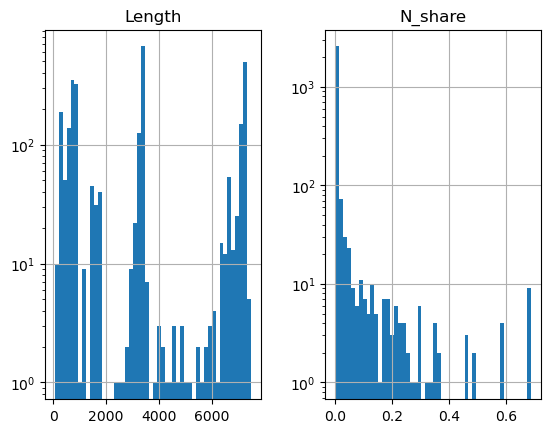

In [31]:
seqstats[['Length', 'N_share']].hist(bins=50, log=True)

## Removing unaligned sequences.

We remove all sequences that were not mapped. Let's have a look at the 10 largest sequences first.

In [32]:
unmapped = seqstats[seqstats['IsForward'].isna()][['Sequence', 'Length', 'N_share']]
print(f'Number of unmapped reads={len(unmapped)}')
unmapped.nlargest(10, ['Length'])

Number of unmapped reads=17


,Sequence,Length,N_share
2812,LC388587.1,281,0.0
2813,LC388588.1,281,0.0
2814,LC388589.1,281,0.0
2815,JQ511992.1,281,0.0
2810,JN651370.1,237,0.0
2811,HM143866.1,237,0.0
2801,JN651374.1,234,0.0
2802,JN651382.1,234,0.0
2803,JN651388.1,234,0.0
2804,JN651389.1,234,0.0


array([[<Axes: title={'center': 'Length'}>,
        <Axes: title={'center': 'N_share'}>]], dtype=object)

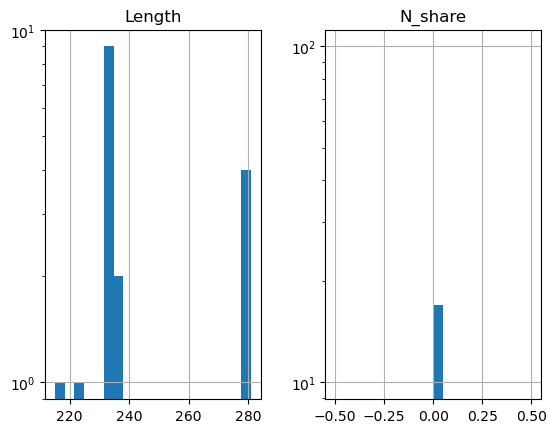

In [33]:
unmapped.hist(bins=20, log=True)

In [34]:
seqstats_mapped = seqstats.dropna(subset='Reference')

## Removing supplementary alignments

Additional to the best hit, minimap2 also sometimes computes supplementary alignments. We remove them here.

In [35]:
seqstats_primary = seqstats_mapped[seqstats_mapped['IsSupplementaryAlignment'] == False]

## Remove short sequences and those with too many Ns

In [ ]:
seqstats_minlen = seqstats_mapped[seqstats_mapped['Length'] >= minlen]
seqstats_high_coverage = seqstats_minlen[seqstats_minlen['N_share'] <= max_n_share]

print('Before filtering:', len(seqstats_mapped))
print(f'N-share larger than {max_n_share}:', len(seqstats_mapped[seqstats_mapped['N_share'] > max_n_share]))
print(f'Length smaller than {minlen}:', len(seqstats_mapped[seqstats_mapped['Length'] < minlen]))
print('After filtering:', len(seqstats_high_coverage))

Before filtering: 2799
N-share larger than 0.01: 301
Length smaller than 2000: 1165
After filtering: 1366


## Remove too short genomes
We remove the genomes that are too short compared to the reference genome.

In [ ]:
seqstats_long_seqs = seqstats_high_coverage[seqstats_high_coverage['RelativeLength'] > min_relative_length]
print(
    f'{len(seqstats_long_seqs)} of {len(seqstats_high_coverage)} sequences '
    f'remain after filtering for {min_relative_length} minimum relative length'
)

1262 of 1366 sequences remain after filtering for 0.95 minimum relative length


Additionally we remove all sequences, where the alignment does not cover enough of the target genome.

In [38]:
seqstats_long_seqs.nsmallest(10, ['ReferenceCoverage'])

,Sequence,Reference,IsForward,ReferenceStart,ReferenceEnd,QueryStart,QueryEnd,EditDistance,IsSupplementaryAlignment,N_share,Length,ReferenceLength,Segment,RelativeLength,RelativeError,ReferenceCoverage,QueryCoverage
2171,KF478769.1,FR832711.1,True,558.0,702.0,0.0,144.0,14.0,True,0.000000,3364,3392.0,S,0.991745,0.097222,0.042453,0.042806
2178,KF478766.1,FR832711.1,True,1672.0,1847.0,0.0,175.0,20.0,True,0.000000,3561,3392.0,S,1.049823,0.114286,0.051592,0.049143
866,FV537334.1,NC_004297.1,True,671.0,7269.0,671.0,7269.0,1488.0,False,0.000000,7279,7279.0,L,1.000000,0.225523,0.906443,0.906443
867,FV537335.1,NC_004297.1,True,671.0,7269.0,671.0,7269.0,1488.0,False,0.000000,7279,7279.0,L,1.000000,0.225523,0.906443,0.906443
2079,MK107954.1,OL774861.1,False,100.0,3216.0,83.0,3238.0,649.0,False,0.000000,3351,3371.0,S,0.994067,0.208280,0.924355,0.941510
1477,MH887856.1,GU481068.1,False,70.0,3271.0,15.0,3217.0,473.0,False,0.000000,3226,3377.0,S,0.955286,0.147766,0.947883,0.992560
2073,OQ791502.1,OL774861.1,False,99.0,3295.0,29.0,3265.0,593.0,False,0.000000,3265,3371.0,S,0.968555,0.185544,0.948087,0.991118
2170,KF478769.1,FR832711.1,False,0.0,3220.0,143.0,3363.0,425.0,False,0.000000,3364,3392.0,S,0.991745,0.131988,0.949292,0.957194
2066,MK117989.1,OL774861.1,False,100.0,3303.0,16.0,3258.0,671.0,False,0.009822,3258,3371.0,S,0.966479,0.209491,0.950163,0.995089
2072,MH053474.1,OL774861.1,False,100.0,3303.0,21.0,3263.0,666.0,False,0.000000,3263,3371.0,S,0.967962,0.207930,0.950163,0.993564


In [ ]:
seqstats_min_ref_cov = seqstats_long_seqs[seqstats_long_seqs['ReferenceCoverage'] >= min_ref_cov]
print(f'Keeping {len(seqstats_min_ref_cov)} of {len(seqstats_long_seqs)} sequences')

Keeping 1254 of 1262 sequences


## Per reference genome counts
Let's have a look what is left after filtering with respect to the distinct reference genomes.

In [40]:
ref_counts_raw = seqstats_primary['Reference'].value_counts()
ref_counts_minlen = seqstats_minlen['Reference'].value_counts()
ref_counts_high_cov = seqstats_high_coverage['Reference'].value_counts()
ref_counts_filtered = seqstats_min_ref_cov['Reference'].value_counts()
pd.DataFrame({'Raw': ref_counts_raw, 'MinLen': ref_counts_minlen, 'MaxN': ref_counts_high_cov,  'Filtered': ref_counts_filtered})

,Raw,MinLen,MaxN,Filtered
Reference,,,,
FR832710.1,37,14,14,6
FR832711.1,57,11,11,8
GU481068.1,853,530,477,459
GU481069.1,499,508,371,332
HQ688672.1,378,70,64,64
HQ688674.1,222,194,160,138
KM822127.1,3,2,2,2
KM822128.1,7,5,5,5
KT992425.1,8,2,2,2


## Statistics after filtering

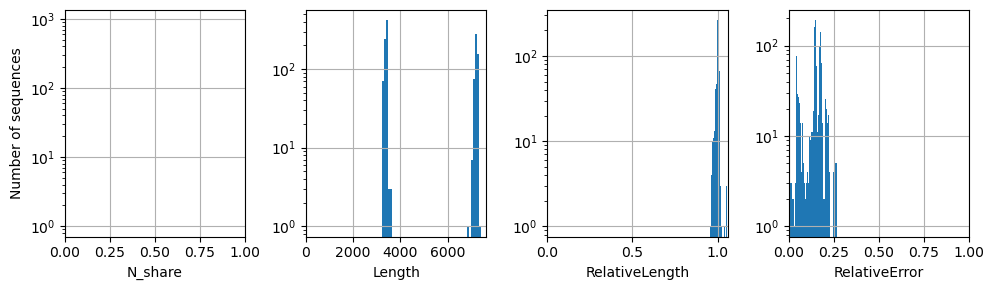

In [41]:
histograms(seqstats_min_ref_cov)

## Read orientation
Finally, lets get the filtered reads with harmonized orientation sorted into the Segments.

In [ ]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import os

df_filtered_final = seqstats_min_ref_cov
os.makedirs(outdir, exist_ok=True)

segments = sorted(set(df_filtered_final['Segment'])) 
fname_template_out = os.path.join(outdir, "{}.fasta")

outfiles = {
    segment: open(fname_template_out.format(segment), 'w')
    for segment in segments
}

segment_and_orientation = {
    row['Sequence']: (row['IsForward'], row['Segment'])
    for _, row in df_filtered_final.iterrows()
}

for record in SeqIO.parse(fname_sequences, "fasta"):
    if record.id not in segment_and_orientation:
        continue
    is_forward, segment = segment_and_orientation[record.id]
    if is_forward is None:
        raise RuntimeError(f"Invalid orientation {is_forward}")
    orientation = 'forward' if is_forward else 'reverse'
    new_record = SeqRecord(
        seq=record.seq if is_forward else record.seq.reverse_complement(),
        id=record.id,
        name=record.name,
        description=f'{record.description}|{orientation}|{segment}'
    )
    SeqIO.write(new_record, outfiles[segment], "fasta")

for outfile in outfiles.values():
    outfile.close()

In [43]:
# hits_merge = seqstats_mapped.groupby('Sequence').agg(
#     N_alignments=('IsForward', 'count'),
#     SameOrientation=('IsForward', lambda x: x.nunique() == 1),
#     SameReference=('Reference', lambda x: x.nunique() == 1),
#     SequenceLength=('Length', 'max'),
# ).reset_index()
# #hits_merge[(hits_merge['SameOrientation'] == False) | (hits_merge['SameReference'] == False)]
# hits_merge[hits_merge['N_alignments'] > 1]